## Load Data From Pickles

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
video_game_tweets_training = pd.read_pickle("saved_pickles/video_game_tweets_training.pkl").head(15000)
unfiltered_tweets_training = pd.read_pickle("saved_pickles/unfiltered_tweets_training.pkl").head(15000)

video_game_tweets_validation = pd.read_pickle("saved_pickles/video_game_tweets_validation.pkl").tail(15000)
unfiltered_tweets_validation = pd.read_pickle("saved_pickles/unfiltered_tweets_validation.pkl").tail(15000)

In [18]:
all_tweets_training = pd.concat([video_game_tweets_training, unfiltered_tweets_training])
all_tweets_validation = pd.concat([video_game_tweets_validation, unfiltered_tweets_validation])

In [17]:
#all_tweets_training = pd.read_pickle("saved_pickles/all_tweets_training.pkl")
#all_tweets_validation = pd.read_pickle("saved_pickles/all_tweets_validation.pkl")

# Perform LSA on Training Set and Transform Testing Set

In [19]:
from lib.lsa import lsa_pipeline
from lib.lsa import run_lsa

In [27]:
all_tweets_training_lsa, vectorizer, svd = lsa_pipeline(all_tweets_training, min_df= 0.001,
                                                        max_df=0.5, num_components=200, stop_words=None)

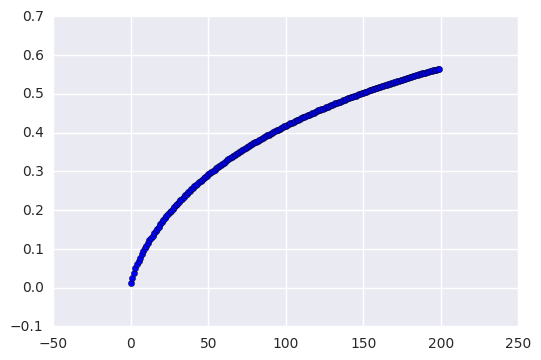

In [28]:
exp_var = svd.explained_variance_ratio_

plt.scatter(x=range(len(exp_var)), y=[sum(exp_var[:i+1]) for i in range(len(exp_var))])

In [32]:
all_tweets_validation_lsa = run_lsa(all_tweets_validation, vectorizer, svd)

In [33]:
from sklearn.externals import joblib

joblib.dump(vectorizer, "saved_pickles/lsa_vectorizer.pkl")
joblib.dump(svd, "saved_pickles/lsa_svd.pkl")
joblib.dump(all_tweets_training_lsa, "saved_pickles/all_tweets_training_lsa.pkl")
joblib.dump(all_tweets_validation_lsa, "saved_pickles/all_tweets_validation_lsa.pkl")

['saved_pickles/all_tweets_validation_lsa.pkl']

# Perform Binary Classification on Video Games vs. Unrelated Tweets

In [35]:
from lib.classification import default_model_set
from lib.classification import grid_search_model

In [36]:
model_set = default_model_set()

In [37]:
X = all_tweets_training_lsa
y = all_tweets_training["game_related_tweet"]

In [38]:
model_results = grid_search_model(model_set, X, y)

K-Nearest Neighbors
{'Standard Scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'Name': 'K-Nearest Neighbors', 'Best_Estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'), 'Score': 0.78333333333333333, 'Grid': GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'Test Score': 0.7924444444444444}
Logistic Regression
{'Standard Scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'Name': 'Logistic Regression', 'Best_Estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
   

In [39]:
model_results.to_pickle("saved_pickles/simple_model_grid_binary_video_game_classification_with_stop_words.pkl")

In [40]:
#model_results.to_pickle("saved_pickles/simple_model_grid_binary_video_game_classification.pkl")

In [41]:
#model_results = pd.read_pickle("saved_pickles/simple_model_grid_binary_video_game_classification.pkl")
model_results[["Name","Score","Test Score"]]

,Name,Score,Test Score
0,K-Nearest Neighbors,0.783333,0.792444
1,Logistic Regression,0.774190,0.781444
2,SVC,0.822619,0.832889
3,Decision Tree,0.744524,0.751778
4,Random Forest,0.783048,0.792778
5,Extra Trees,0.790571,0.794000


In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_params = {'criterion':['gini','entropy'], 'n_estimators':[2,5,10,20],
             'max_features':[None, 'auto', 'sqrt','log2']}

random_forest_grid = [["Random Forest", rf, rf_params]]

In [43]:
random_forest_results = grid_search_model(random_forest_grid, X, y)

Random Forest
{'Standard Scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'Name': 'Random Forest', 'Best_Estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), 'Score': 0.8059047619047619, 'Grid': GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
  

In [44]:
#random_forest_results.to_pickle("saved_pickles/random_forest_grid_model.pkl")
random_forest_results.to_pickle("saved_pickles/random_forest_grid_model_with_stop_words.pkl")

In [45]:
#random_forest_results = pd.read_pickle("saved_pickles/random_forest_grid_model.pkl")
random_forest_results

,Best_Estimator,Grid,Name,Score,Standard Scaler,Test Score
0,"(DecisionTreeClassifier(class_weight=None, cri...","GridSearchCV(cv=5, error_score='raise',\n ...",Random Forest,0.805905,"StandardScaler(copy=True, with_mean=True, with...",0.813


In [46]:
best_model = model_results["Best_Estimator"].loc[2]
scaler = model_results["Standard Scaler"].loc[2]

In [47]:
validation_true = all_tweets_validation["game_related_tweet"]
validation_pred = best_model.predict(scaler.transform(all_tweets_validation_lsa))

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [49]:
from sklearn.metrics import accuracy_score

In [50]:
test = pd.DataFrame(validation_true)
test.index = range(validation_true.shape[0])

In [51]:
accuracy_score(y_true = validation_true, y_pred = validation_pred)

0.76513333333333333

In [52]:
print classification_report(y_true = validation_true, y_pred = validation_pred)

             precision    recall  f1-score   support

          0       0.70      0.93      0.80     15000
          1       0.90      0.60      0.72     15000

avg / total       0.80      0.77      0.76     30000



In [53]:
cm = confusion_matrix(y_true = validation_true, y_pred = validation_pred)

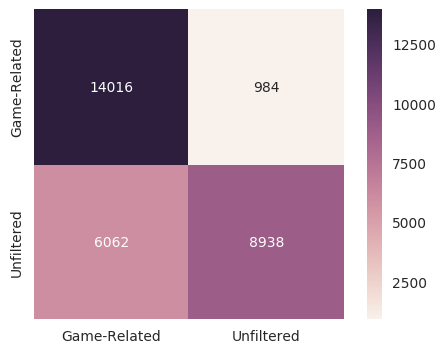

In [54]:
names = ["Game-Related", "Unfiltered"]
sns.heatmap(cm, square=True,annot=True,fmt='d',cbar=True,
            xticklabels=names, yticklabels=names)